![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Advanced Predictive Modeling with Python 
## Session #1: Features
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

# Preliminaries

1.  If you haven't do so already, download and **install the [Anaconda Scientific Python Distribution version 2.7](https://store.continuum.io/cshop/anaconda/)**.  If it offers to make itself your default Python distribution, allow it.
1. Whether you've just installed Anaconda, or you have done so previously, you should now **update Anaconda** to the latest version of the distribution.  It changes a lot so do this today even if you did recently.
 1. Open a terminal or command prompt.
 1. Type ```conda update conda``` and press enter or return.  Confirm that you'd like it to make any changes that it offers.
 1. Type ```conda update anaconda``` and press enter or return.  Confirm that you'd like it to make any changes that it offers.
1. **Download the code repository**.  
 1. Go to [bit.ly/uci_predictive](http://bit.ly/uci_predictive) and click the "download zip" button on the right to download a zip file containing this entire repository.
 1. Unzip that file into a directory you know how to find; you'll need it several times throughout the day.  
1. **Start an ipython notebook server**.
 1. Open a terminal and type ```ipython notebook```.  Navigate to the directory where you unzipped this repository.
 1. Open "Test Notebook.ipynb".
 1. Click "Cell" at the top of the opened notebook, followed by "Run All" and ensure that 1) there are no errors and that 2) the output from the first cell is the same as that in the second.  If it doesn't match, raise your hand.
 1. If everything looks good, close the browser tab containing the test notebook but keep open the tab listing all the other notebooks.
 
### Schedule for Today

|Start Time | Session |
|-----------|---------|
|8:30am     | Check In|
|9:00am     | **Feature Engineering** |
|10:30am    | Coffee & Bagels|
|10:45am    | **Ensembling** |
|12:30pm    | End|

### Goals of this Lesson
- Extend the regression framework to support classification
    - Logistic Regression
    - Training with Gradient Descent
    - Training with Newton's Method
    
- Implement... 
    - The Logistic Function
    - A function to compute the Hessian matrix
    - An instantiation of SciKit-Learn's Logistic regression class

### References 
- Chapter 14 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf)
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's documentation on data preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- [SciKit-Learn's documentation on dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [168]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created some functions that we'll use later to create visualizations.  They are a bit messy and not essential to the material so don't worry about understanding them.  I'll be happy to explain them to anyone interested during a break or after the session.  

In [169]:
from matplotlib.colors import ListedColormap

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, coord_type='cart', court_image = '../data/nba/nba_court.jpg'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    features = np.c_[grid_x.ravel(), grid_y.ravel()]
    # change coordinate system
    if coord_type == 'polar':
        features = np.c_[grid_x.ravel(), grid_y.ravel()]
        hoop_location = np.array([25., 0.])
        features -= hoop_location
        dists = np.sqrt(np.sum(features**2, axis=1))
        angles = np.arctan2(features[:,1], features[:,0])
        features = np.hstack([dists[np.newaxis].T, angles[np.newaxis].T])
        
    grid_predictions = log_reg_model.predict(features)
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

We also need functions for performing common tasks such as shuffling the data and calculating classification errrors.  

In [170]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

### calculate mean squared error (MSE)
def calc_mse(predictions, responses):
    return np.mean( (predictions - responses)**2 )

## 1.  Warm-up

Let's start with a warm-up exercise.  In the data directory you'll find a dataset of recent movies and their ratings as given by several popular websites.  Let's load it with Pandas...  

In [171]:
# load a dataset of recent movies and their ratings across several websites
movie_data = pd.read_csv('../data/movie_ratings.csv')
# reduce it to just the ratings categories
movie_data = movie_data[['FILM','RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue', 'IMDB']]
movie_data.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
0,Avengers: Age of Ultron (2015),74,86,66,7.1,4.5,7.8
1,Cinderella (2015),85,80,67,7.5,4.5,7.1
2,Ant-Man (2015),80,90,64,8.1,4.5,7.8
3,Do You Believe? (2015),18,84,22,4.7,4.5,5.4
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,3.0,5.1


In [172]:
movie_data.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,3.845205,6.736986
std,30.168799,20.024430,19.517389,1.510712,0.502831,0.958736
min,5.000000,20.000000,13.000000,2.400000,2.700000,4.000000
25%,31.250000,50.000000,43.500000,5.700000,3.500000,6.300000
50%,63.500000,66.500000,59.000000,6.850000,3.900000,6.900000
75%,89.000000,81.000000,75.000000,7.500000,4.200000,7.400000
max,100.000000,94.000000,94.000000,9.600000,4.800000,8.600000


### Logistic Regression Review

_**Data**_

We observe pairs $(\mathbf{x}_{i},y_{i})$ where
\begin{eqnarray*}
y_{i} \in \{ 0, 1\} &:& \mbox{class label} \\
\mathbf{x}_{i} = (1, x_{i,1}, \dots, x_{i,D}) &:& \mbox{set of $D$ explanatory variables (aka features) and a bias term } 
\end{eqnarray*}

_** Parameters**_

\begin{eqnarray*}
\mathbf{\beta}^{T} = (\beta_{0}, \dots, \beta_{D}) : \mbox{values encoding the relationship between the features and label}
\end{eqnarray*}

_** Transformation Function **_

\begin{equation*}
f(z_{i}=\mathbf{x}_{i} \mathbf{\beta} ) = (1+e^{-\mathbf{x}_{i} \mathbf{\beta} })^{-1}
\end{equation*}

_**Error Function**_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log f(\mathbf{x}_{i} \mathbf{\beta} ) - (1-y_{i}) \log (1-f(\mathbf{x}_{i} \mathbf{\beta} ))
\end{eqnarray*}

_** Learning $\beta$ **_
- Randomly initialize $\beta$
- Until $\alpha || \nabla \mathcal{L} || < tol $:
    - $\mathbf{\beta}_{t+1} = \mathbf{\beta}_{t} - \alpha \nabla_{\mathbf{\beta}} \mathcal{L}$

## <span style="color:red">STUDENT ACTIVITY (10 MINS)</span> 
Run a logistic regression model on this data with SciKit-Learn.  If you need a refresher, [check out the notebook from the first course](https://github.com/UCIDataScienceInitiative/PredictiveModeling_withPython/blob/master/Session%203%20-%20Classification.ipynb) and the [SciKit-Learn documentation on logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [200]:
from sklearn import linear_model

# set the random number generator for reproducability
np.random.seed(123)

# let's try to predict the IMDB rating from the others
features = movie_data[['RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue']].as_matrix()
# create classes: more or less that 7/10 rating
labels = (movie_data['IMDB'] >= 7.).astype('int')
shuffle_in_unison(features, labels)

### Your Code Goes Here ###

# initialize and train a logistic regression model
lm = linear_model.LogisticRegression()
lm.fit(features, labels)

# compute error on training data
predictions = lm.predict(features)
train_error_rate = calc_classification_error(predictions, labels)

###########################

print "Classification error on training set: %.2f%%" %(calc_classification_error(predictions, labels)*100)

Classification error on training set: 9.59%


## 2.  Feature Transformations
Good features are crucial for training well-performing classifiers: 'garbage in, garbage out.'  In this section we introduce several transformations that are commonly applied to data as a preprocessing step before training a classifier.

### 2.1 Normal Standardization
Recall the formula of the standard linear model: $$\hat Y = f(\beta^{T} \mathbf{X}) $$ where $\hat Y$ is the predictions, $f(\cdot)$ is the transformation function, $\beta$ is the weights (parameters), and $X$ is the $N \times d$ matrix of features.  For simplicity, assume there are just two features: $$ \beta^{T} X_{i} = \beta_{1}x_{i,1} + \beta_{2}x_{i,2}.$$  Usually $x_{i,1}$ and $x_{i,2}$ will be measured in different units.  For instance, in the movie ratings data, the Rotten Tomatoes dimension is on a $0-100$ scale and the Fandango ratings are on $0-5$.  The difference in scale causes one dimension to dominate the inner product.  Linear models can learn to cope with this imbalance by changing the scales of the weights accordingly, but this makes optimization harder because gradient steps are unequal across dimensions.

One way to get rid of hetergeneous scales is to standardize the data so that the values in each dimension are distributed according to the standard Normal distribution.  In math, this means we'll transform the data like so: $$\mathbf{X}_{std} = \frac{\mathbf{X} - \mu_{X}}{\sigma_{X}}. $$  This is also called 'z-score scaling.'  Let's examine the affect of this transformation on training error.

In [201]:
# perform z-score scaling
features_mu = np.mean(features, axis=0)
features_sigma = np.std(features, axis=0)
std_features = (features - features_mu)/features_sigma

# re-train model
lm.fit(std_features, labels)

### compute error on training data
predictions = lm.predict(std_features)
print "Classification error on training set: %.3f%%" %(calc_classification_error(predictions, labels)*100)

Classification error on training set: 7.534%


Standard Normal scaling is a common and usually default first step, especially when you know the data in measured in different units.

### 2.2 Log Transformations

### 2.3 Domain-Specific Transformations

In [202]:
nba_shot_data = pd.read_csv('../data/nba/NBA_xy_features.csv')
nba_shot_data.head()

,x_Coordinate,y_Coordinate,shot_outcome
0,26.0,32.0,0.0
1,25.0,24.0,0.0
2,25.0,6.0,1.0
3,40.0,7.0,1.0
4,12.0,13.0,1.0


Training ended after 0.44 seconds.
Classification Error on the Test Set: 41.87%
Baseline Error: 45.79%


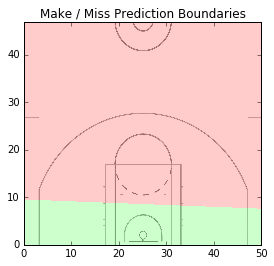

In [203]:
# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']].as_matrix()
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']].as_matrix()
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']].as_matrix()
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']].as_matrix()

#Train logistic regression model
start_time = time.time()
lm.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = lm.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm)

In [204]:
### Transform coordinate system

# radius coordinate: calculate distance from point to hoop
hoop_location = np.array([25.5, 0.])
train_features -= hoop_location
test_features -= hoop_location
train_dists = np.sqrt(np.sum(train_features**2, axis=1))
test_dists = np.sqrt(np.sum(test_features**2, axis=1))

# angle coordinate: use arctan2 function
train_angles = np.arctan2(train_features[:,1], train_features[:,0])
test_angles = np.arctan2(test_features[:,1], test_features[:,0])

# combine vectors into polar coordinates
polar_train_features = np.hstack([train_dists[np.newaxis].T, train_angles[np.newaxis].T])
polar_test_features = np.hstack([test_dists[np.newaxis].T, test_angles[np.newaxis].T])

pd.DataFrame(polar_train_features, columns=["Radius","Angle"]).head()

,Radius,Angle
0,32.003906,1.555173
1,24.005208,1.591627
2,6.020797,1.653938
3,16.101242,0.449760
4,18.741665,2.375060


Training ended after 0.51 seconds.
Classification Error on the Test Set: 40.92%
Baseline Error: 45.79%


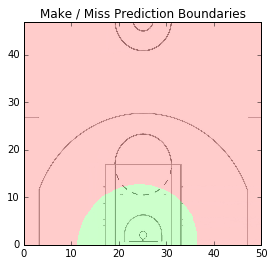

In [205]:
#Train model
start_time = time.time()
lm.fit(polar_train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on test data
predictions = lm.predict(polar_test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm, coord_type='polar')

## 3.  Dimensionality Reduction
Sometimes the data calls for more aggressive transformations.  High-dimensional data is usually hard to model because classifiers are likely to [overfit](https://en.wikipedia.org/wiki/Overfitting).  Regularization is one way to combat high dimensionality, but often it can not be enough.  This section will cover *dimensionality reduction*--a technique for reducing the number of features while still preserving curcial information.  This is a form of unsupervised learning since we use no class information.    

### 3.1 Image Dataset: [Bob Ross](https://en.wikipedia.org/wiki/Bob_Ross) Paintings
![alt text](http://i2.wp.com/espnfivethirtyeight.files.wordpress.com/2014/04/bob-ross1.jpg?quality=70&strip=all&w=600&ssl=1 'Bob_Ross_Banner')
In this section we'll use a dataset of [Bob Ross'](https://en.wikipedia.org/wiki/Bob_Ross) paintings.  Images are a type of data that notoriously have redundant features and whose dimensionality can be reduced significantly, without much loss of information.  We'll explore this phenomenom via 403 $400 \times 300$ full-color images of natural landscape paintings.

Before we load the data, let's take a minute to review how image data is stored on a computer.  Of course, all the computer sees are numbers ranging from 0 to 255.  Each pixel takes on one of these values.  Furthermore, there are three layers to color images--one for red, blue, and green values.  Therefore, the painting we'll examine are represented as $300 \times 400 \times 3$-dimensional tensors (multi-dimensional arrays).  This layering is depicted below.

![image_data_format](../graphics/image_data_format.png)

While images need to be represented with three dimensions to be visualized, the learning algorithms we'll consider don't need any notion of color values so I've already flattened the images into vector form, i.e. to create a matrix of size $403 \times 360000$.  Let's load the dataset...

In [179]:
# load the Pillow image library
import PIL.Image as pImage

# un-zip the paintings file
import zipfile
zipper = zipfile.ZipFile('../data/bob_ross/bob_ross_paintings.npy.zip')
zipper.extractall('../data/bob_ross/')

# load the 403 x 360,000 matrix
br_paintings = np.load(open('../data/bob_ross/bob_ross_paintings.npy','rb'))
print "Dataset size: %d x %d"%(br_paintings.shape)

Dataset size: 403 x 360000


and then visualize two of the images...

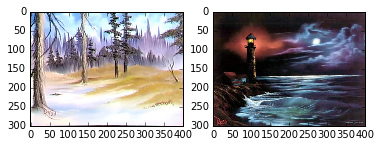

In [180]:
# subplot containing first image
ax1 = plt.subplot(1,2,1)
br_painting = br_paintings[70,:]
ax1.imshow(np.reshape(br_painting, (300, 400, 3)))

# subplot containing second image
ax2 = plt.subplot(1,2,2)
br_painting = br_paintings[33,:]
ax2.imshow(np.reshape(br_painting, (300, 400, 3)))
plt.show()

### 3.2 Principal Component Analysis

As we've seen, the dataset has many, many, many more features (columns) than examples (rows).  Simple Lasso or Ridge regularization methods probably won't be enough to prevent overfitting so we have to do something more drastic.  In this section, we'll cover [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), a popular technique for reducing the dimensionality of data.

#### <span style="color:red">Caution: Running PCA can take from 30 seconds to several minutes.</span> 

In [181]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
start_time = time.time()
reduced_paintings = pca.fit_transform(br_paintings)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 

print "Dataset is now of size: %d x %d"%(reduced_paintings.shape)

Training took a total of 21.02 seconds.
Preserved percentage of original variance: 99.99%
Dataset is now of size: 403 x 400


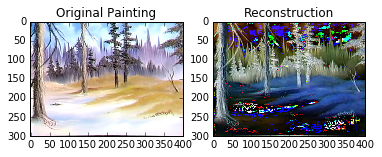

In [182]:
img_idx = 70
reconstructed_img = pca.inverse_transform(reduced_paintings[img_idx,:])
original_img = br_paintings[70,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (300, 400, 3)))
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (300, 400, 3)))
ax2.set_title("Reconstruction")
plt.show()

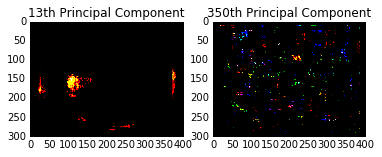

In [183]:
# get the transformation matrix
transformation_mat = pca.components_
# two components to show
comp1 = 13
comp2 = 350

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = transformation_mat[comp1-1,:]
ax1.imshow(np.reshape(filter1, (300, 400, 3)))
ax1.set_title("%dth Principal Component"%(comp1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = transformation_mat[comp2-1,:]
ax2.imshow(np.reshape(filter2, (300, 400, 3)))
ax2.set_title("%dth Principal Component"%(comp2))
plt.show()

### 3.3 PCA for Visualization

In [184]:
# get the movie features
movie_features = movie_data[['RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue']].as_matrix()

# perform standard scaling again but via SciKit-Learn
from sklearn.preprocessing import StandardScaler
z_scaler = StandardScaler()
movie_features = z_scaler.fit_transform(movie_features)

pca = PCA(n_components=2)
start_time = time.time()
movie_2d_proj = pca.fit_transform(movie_features)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(movie_2d_proj.shape)

Training took a total of 0.00 seconds.
Preserved percentage of original variance: 91.21%
Dataset is now of size: 146 x 2


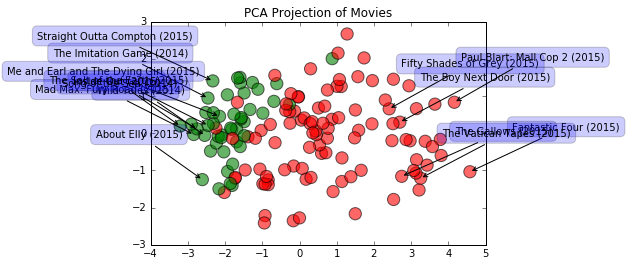

In [185]:
labels = movie_data['FILM'].tolist()
classes = movie_data['IMDB'].tolist()

# color the points by IMDB ranking
labels_to_show = []
colors = []
for idx, c in enumerate(classes):
    if c > 7.25:
        colors.append('g')
        if c > 8.:
            labels_to_show.append(labels[idx])
    else:
        colors.append('r')
        if c < 4.75:
            labels_to_show.append(labels[idx])

# plot data
plt.scatter(movie_2d_proj[:, 0], movie_2d_proj[:, 1], marker = 'o', c = colors, s = 150, alpha = .6)

# add movie title annotations
for label, x, y in zip(labels, movie_2d_proj[:, 0].tolist(), movie_2d_proj[:, 1].tolist()):
    if label not in labels_to_show:
        continue
    if x < 0:
        text_x = -20
    else:
        text_x = 150
    plt.annotate(label.decode('utf-8'),xy = (x, y), xytext = (text_x, 40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'),
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'b', alpha = 0.2))
    
plt.title('PCA Projection of Movies')
plt.show()

## <span style="color:red">STUDENT ACTIVITY (until end of session)</span> 

Your task is to...

Dataset size: 400 x 4096
And the images look like this...


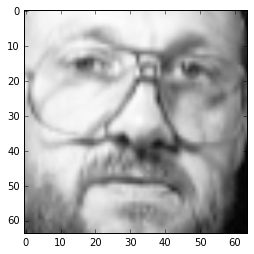

In [186]:
from sklearn.datasets import fetch_olivetti_faces

faces_dataset = fetch_olivetti_faces(shuffle=True)
faces = faces_dataset.data # 400 flattened 64x64 images
person_ids = faces_dataset.target # denotes the identity of person (40 total)

print "Dataset size: %d x %d" %(faces.shape)
print "And the images look like this..."
plt.imshow(np.reshape(faces[200,:], (64, 64)), cmap='Greys_r')
plt.show()

### <span style="color:red">Subtask 1: Run PCA</span> 

In [187]:
### Your code goes here ###

# train PCA model on 'faces'
pca = PCA(n_components=100)

start_time = time.time()
faces_reduced = pca.fit_transform(faces)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(faces_reduced.shape)
###########################

Training took a total of 0.10 seconds.
Preserved percentage of original variance: 93.54%
Dataset is now of size: 400 x 100


### <span style="color:red">Subtask 2: Reconstruct an image</span> 

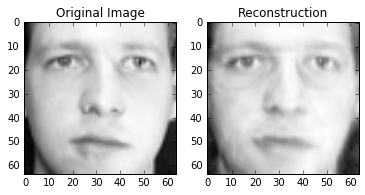

In [188]:
### Your code goes here ###

# Use learned transformation matrix to project back to the original 4096-dimensional space
# Remember you need to use np.reshape() 

img_idx = 70
reconstructed_img = pca.inverse_transform(faces_reduced[img_idx,:])
original_img = faces[70,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (64, 64)), cmap='Greys_r')
ax1.set_title("Original Image")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (64, 64)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()

###########################

Your output should look something like what's below (although could be a different face):
![reconstruction_solution](../graphics/face_reconstruction_soln.png)

### <span style="color:red">Subtask 2: Visualize a component of the transformation matrix</span> 

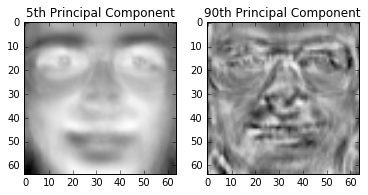

In [189]:
### Your code goes here ###

# Now visualize one of the principal components
# Again, remember you need to use np.reshape() 

# get the transformation matrix
transformation_mat = pca.components_
# two components to show
comp1 = 5
comp2 = 90

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = transformation_mat[comp1-1,:]
ax1.imshow(np.reshape(filter1, (64, 64)), cmap='Greys_r')
ax1.set_title("%dth Principal Component"%(comp1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = transformation_mat[comp2-1,:]
ax2.imshow(np.reshape(filter2, (64, 64)), cmap='Greys_r')
ax2.set_title("%dth Principal Component"%(comp2))
plt.show()

###########################

Your output should look something like what's below (although could have differently ranked components):
![reconstruction_solution](../graphics/face_components_soln.png)

### <span style="color:red">Subtask 3: Generate a 2D scatter plot</span> 

Training took a total of 0.12 seconds.
Preserved percentage of original variance: 37.81%
Dataset is now of size: 400 x 2


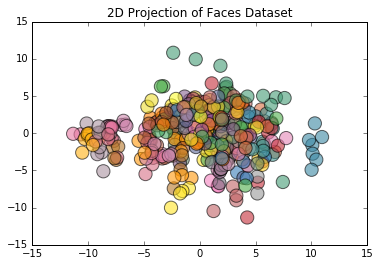

In [190]:
### Your code goes here ###

# Train another PCA model to project the data into two dimensions
# Bonus: color the scatter plot according to the person_ids to see if any structure can be seen

# Run PCA for 2 components
pca = PCA(n_components=2)
start_time = time.time()
faces_2d_proj = pca.fit_transform(faces)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(faces_2d_proj.shape)

# Generate plot

# color the points by the person ids
colors = [plt.cm.Set1((c+1)/40.) for c in person_ids]

# plot data
plt.scatter(faces_2d_proj[:, 0], faces_2d_proj[:, 1], marker = 'o', c = colors, s = 175, alpha = .6)
plt.title('2D Projection of Faces Dataset')
plt.show()

###########################